In [7]:
from helpers import *
import numpy as np

#sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_palette("colorblind")

mpl.rcParams["axes.titlesize"] = 15.
mpl.rcParams["axes.labelsize"] = 15.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = "serif"

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

df = load_benchmark_data(load_ppo=True)
df

We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-3000-2024-11-20-14-34-02.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-4000-2024-11-20-14-34-02.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-4000-2024-11-20-14-38-41.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-2000-2024-11-20-14-34-02.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-2000-2024-11-20-14-38-42.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-1000-2024-11-20-14-31-48.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-000-2024-11-20-14-31-48.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-000-2024-11-20-14-36-29.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-1000-2024-11-20-14-36-29.
We have a EmptyDataError for SafetyRacecarCircle1-v0/p3o/seed-3000-2024-11-20-14-38-42.
We have a EmptyDataError for SafetyRacecarCircle1-v0/ipo/seed-1000-2024-11-21-09-26-48.
We have a EmptyDataError for Safet

,Metrics/EpRet,Metrics/EpCost,Metrics/EpLen,Metrics/EpCostRegret,Train/Epoch,Train/TotalSteps,Train/KL,Train/div,Train/target_div,Loss/Loss_reward_critic,...,Misc/optim_case,seed,algo,env,exp,Metrics/EpCumCostViolation,Train/StopIter,Train/LagragianMultiplier,Train/LR,Train/SeconStageStopIter
239999,1.087685,42.837,1000.0,1650.45,500,10000000,0.003853,0.003853,0.01,0.012311,...,0.0,seed-1000-2024-11-16-17-47-55,C-TRPO,SafetyCarButton1-v0,ablation,5617.207778,NaN,NaN,NaN,NaN
227494,1.058466,33.303,1000.0,1364.95,495,9900000,0.004727,0.004727,0.01,0.003867,...,0.0,seed-4000-2024-11-18-12-22-40,C-TRPO,SafetyPointPush1-v0,ablation,3158.476699,NaN,NaN,NaN,NaN
227495,1.143474,38.389,1000.0,1579.55,496,9920000,0.004175,0.004175,0.01,0.005362,...,0.0,seed-4000-2024-11-18-12-22-40,C-TRPO,SafetyPointPush1-v0,ablation,3171.865699,NaN,NaN,NaN,NaN
227496,1.107636,35.079,1000.0,1419.60,497,9940000,0.003885,0.003885,0.01,0.004112,...,0.0,seed-4000-2024-11-18-12-22-40,C-TRPO,SafetyPointPush1-v0,ablation,3181.944699,NaN,NaN,NaN,NaN
227497,0.947750,20.536,1000.0,769.40,498,9960000,0.005184,0.005193,0.01,0.005957,...,1.0,seed-4000-2024-11-18-12-22-40,C-TRPO,SafetyPointPush1-v0,ablation,3181.944699,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194995,0.735066,42.089,1000.0,1621.15,496,9920000,0.003392,0.003392,0.01,0.011170,...,0.0,seed-1000-2024-09-05-10-16-32,NaN,SafetyCarButton1-v0,benchmark,4502.817285,NaN,NaN,NaN,NaN
194996,0.710611,46.519,1000.0,1832.30,497,9940000,0.003980,0.003980,0.01,0.007250,...,0.0,seed-1000-2024-09-05-10-16-32,NaN,SafetyCarButton1-v0,benchmark,4524.336285,NaN,NaN,NaN,NaN
194997,0.536634,44.067,1000.0,1800.85,498,9960000,0.003701,0.003701,0.01,0.005366,...,0.0,seed-1000-2024-09-05-10-16-32,NaN,SafetyCarButton1-v0,benchmark,4543.403285,NaN,NaN,NaN,NaN
194998,0.366875,28.634,1000.0,1125.65,499,9980000,0.003226,0.003226,0.01,0.005191,...,0.0,seed-1000-2024-09-05-10-16-32,NaN,SafetyCarButton1-v0,benchmark,4547.037285,NaN,NaN,NaN,NaN


In [4]:
normalized_score_dict = {}

for metric in metrics:
    normalized_score_dict[metric] = {}
    for algo in ALGOS:
        normalized_score_dict[metric][algo] = np.zeros((5, len(ENVS)))
        for i, env in enumerate(ENVS):
            df_filtered = df[df["Train/TotalSteps"] == 10000000]
            df_filtered = df_filtered[df_filtered["env"] == env]
            if metric == "Metrics/EpRet":
                norm = df_filtered[df_filtered["algo"]=="PPO"][metric].mean()
            elif metric == "Metrics/EpCost":
                norm = 25.0
            else:  # "Metrics/EpCumCostViolation"
                norm = df_filtered[df_filtered["algo"]=="CPO"][metric].mean()
            data = np.array(df_filtered[df_filtered["algo"]==algo][metric])
            if not data.size == 0:
                normalized_score_dict[metric][algo][:len(data),i] = data / norm
            else:
                print(f"Warning: empty data for {algo}, {env}")

normalized_score_dict


{'Metrics/EpRet': {'C-TRPO': array([[0.57328121, 0.39364136, 0.86800419, 0.2329602 , 0.06038147,
          0.79835463, 0.77118163, 1.00662458],
         [0.56412213, 0.43105401, 0.89154178, 0.94041628, 0.08553064,
          0.80457013, 0.77345412, 0.60774959],
         [0.57632145, 0.4132339 , 0.87957656, 0.93530748, 0.00937827,
          0.76385667, 0.6939407 , 1.43218177],
         [0.57254676, 0.4174856 , 0.87769674, 0.90218478, 0.0719416 ,
          0.79732092, 0.70169446, 0.61513368],
         [0.5858337 , 0.42457254, 0.88830917, 0.8885383 , 0.02643403,
          0.75968054, 0.78884861, 1.28408288]]),
  'CPO': array([[0.5806501 , 0.4309137 , 0.84019031, 0.9230177 , 0.07094954,
          0.81313363, 0.70162889, 0.41679951],
         [0.55024553, 0.40598704, 0.96313051, 0.92976083, 0.05111266,
          0.85825694, 0.72253029, 0.36887045],
         [0.57461586, 0.43310122, 0.88565753, 0.93612855, 0.06010015,
          0.74174   , 0.73410099, 1.34644792],
         [0.57473243, 0.4140

In [5]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

aggregate_scores, aggregate_score_cis = {}, {}

metric_names = [
    "Reward", 
    "Final Cost", 
    "Cumulative Cost"
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    #"eval_reward",
    #"eval_cost",
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

for metric, metric_name in zip(metrics, metric_names):
    aggregate_scores[metric_name], aggregate_score_cis[metric_name] = rly.get_interval_estimates(
        normalized_score_dict[metric], 
        rl_metrics.aggregate_iqm, 
        reps=50000
    )

In [6]:
as_df = pd.DataFrame(aggregate_scores).melt(ignore_index=False).reset_index()
as_df = as_df.rename(columns={"index": "algo", "variable": "metric"})

as_ci_df = pd.DataFrame(aggregate_score_cis).melt(ignore_index=False).reset_index()
as_ci_df = as_ci_df.rename(columns={"index": "algo", "variable": "metric", "value": "ci"})

as_df.merge(as_ci_df)

,algo,metric,value,ci
0,C-TRPO,Reward,0.696232,"[[0.6447937994574904], [0.7412067510285343]]"
1,CPO,Reward,0.680155,"[[0.6353953077569919], [0.7295562200190222]]"
2,PCPO,Reward,0.444720,"[[0.39904816515260727], [0.4883321140077995]]"
3,CPPO-PID,Reward,0.517230,"[[0.4596712805677301], [0.5687389136880355]]"
4,PPO-Lag,Reward,0.471180,"[[0.41664426809483934], [0.5139449191163353]]"
5,TRPO-Lag,Reward,0.597762,"[[0.5140608617910413], [0.6754772066958996]]"
6,FOCOPS,Reward,0.614284,"[[0.5636952542222188], [0.6670244842648366]]"
7,CUP,Reward,0.648349,"[[0.5942151024737212], [0.700326140971575]]"
8,P3O,Reward,0.451609,"[[0.4018238225571278], [0.5050013962064676]]"
9,IPO,Reward,0.426489,"[[0.37042101330097815], [0.4880976683697074]]"


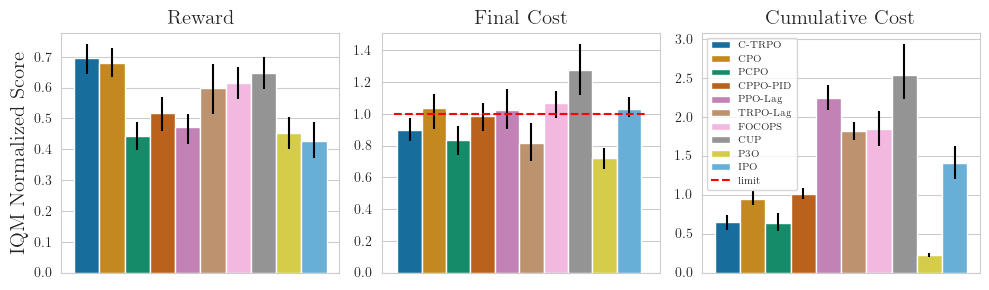

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for metric_name, ax in zip(metric_names, axs):
    sns.barplot(as_df[as_df["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax)
    plt.tight_layout()

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:10]])))
    y = np.array(as_df[as_df["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df[as_df["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("IQM Normalized Score" if metric_name == "Reward" else "")
    ax.set_title(metric_name)

axs[1].plot([-0.41, 0.42], [1, 1], color="red", linestyle="dashed", label="limit", zorder=10)

handles, labels = axs[1].get_legend_handles_labels()
    
axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)

plt.legend(handles, labels, prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("..", "graphics", f"benchmark.pdf"), dpi=600)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), sharey=False)

for metric_name, ax in zip([metric_names[0], metric_names[2]], axs):
    sns.barplot(as_df[as_df["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax)
    plt.tight_layout()

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:10]])))
    y = np.array(as_df[as_df["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df[as_df["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("IQM Normalized Score" if metric_name == "Reward" else "")
    ax.set_title(metric_name)

handles, labels = axs[0].get_legend_handles_labels()
    
axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)

plt.legend(handles, labels, prop={'size': 6.5})

plt.tight_layout()

plt.savefig(os.path.join("img", f"rliable_benchmark_summary.pdf"), dpi=600)

In [19]:
import numpy as np

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for i, env in enumerate(ENVS):
    normalized_score_dict_samples[env] = {}
    for metric in metrics:
        normalized_score_dict_samples[env][metric] = {}
        for algo in ALGOS:
            normalized_score_dict_samples[env][metric][algo] = np.zeros((5, 10))
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                if metric == "Metrics/EpRet":
                    norm = df_filtered[(df_filtered["algo"]=="PPO") & (df_filtered["Train/TotalSteps"] == 10_000_000)][metric].mean()
                elif metric == "Metrics/EpCost":
                    norm = 25.0
                else:  # "Metrics/EpCumCostViolation"
                    norm = df_filtered[(df_filtered["algo"]=="CPO") & (df_filtered["Train/TotalSteps"] == 10_000_000)][metric].mean()
                data = np.array(df_filtered[(df_filtered["algo"]==algo) & (df_filtered["Train/TotalSteps"] == step)][metric])
                if not data.size == 0:
                    normalized_score_dict_samples[env][metric][algo][:,j] = data / norm
                else:
                    print(f"Warning: empty data for {algo}, {env}")

In [21]:
normalized_score_dict_samples["SafetyAntVelocity-v1"]['Metrics/EpRet']['C-TRPO'].shape

(5, 10)

this takes a couple minutes to run:

In [24]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

iqm_scores, iqm_cis = {}, {}

for env in ENVS:
  print(f"IQM scores for {env}... ", end="")
  iqm_scores[env] = {}
  iqm_cis[env] = {}
  for metric, metric_name in zip(metrics, metric_names):
    print(f"{metric_name}", end="")
    iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                  for frame in range(scores.shape[-1])])

    iqm_scores[env][metric_name], iqm_cis[env][metric_name] = rly.get_interval_estimates(
      normalized_score_dict_samples[env][metric], iqm, reps=50000)
    print(f", ", end="")
  print("")

instead you can load the iqm scores/cis from file

In [39]:
import pickle

with open(os.path.join("..", "data", "runs", "iqm_envs.pickle"), "rb") as f:
    iqm_scores, iqm_cis = pickle.load(f)

In [40]:
iqm_scores, iqm_cis

({'SafetyAntVelocity-v1': {'Reward': {'C-TRPO': array([0.33723296, 0.49219759, 0.52442064, 0.54804552, 0.55445467,
           0.55651798, 0.56336917, 0.56873202, 0.56945756, 0.5740498 ]),
    'CPO': array([0.28206197, 0.42418486, 0.49025254, 0.5216569 , 0.55376296,
           0.55510057, 0.55634548, 0.56755616, 0.57188295, 0.57548273]),
    'PCPO': array([0.01077527, 0.17168379, 0.22726461, 0.26672513, 0.29026165,
           0.30445447, 0.29019309, 0.31340397, 0.31694071, 0.31671964]),
    'CPPO-PID': array([0.00827045, 0.15753894, 0.30402966, 0.42397701, 0.47809619,
           0.52172213, 0.54980263, 0.56114106, 0.58562895, 0.59373813]),
    'PPO-Lag': array([0.00827045, 0.15753894, 0.32247789, 0.44569904, 0.48366126,
           0.52343025, 0.55068426, 0.55937511, 0.58530167, 0.59475284]),
    'TRPO-Lag': array([0.28858405, 0.51051489, 0.53197933, 0.5500663 , 0.55894139,
           0.55365876, 0.57844596, 0.56689635, 0.57839497, 0.55606238]),
    'FOCOPS': array([-0.00184039,  0.13340

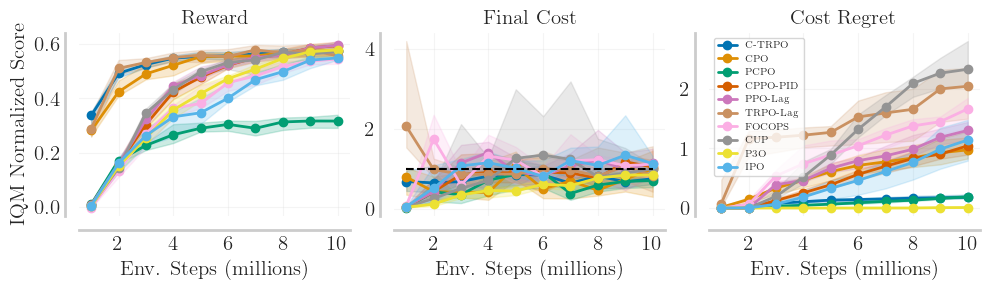

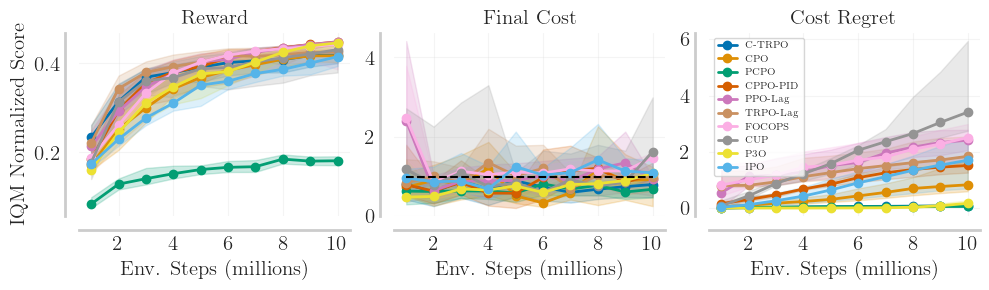

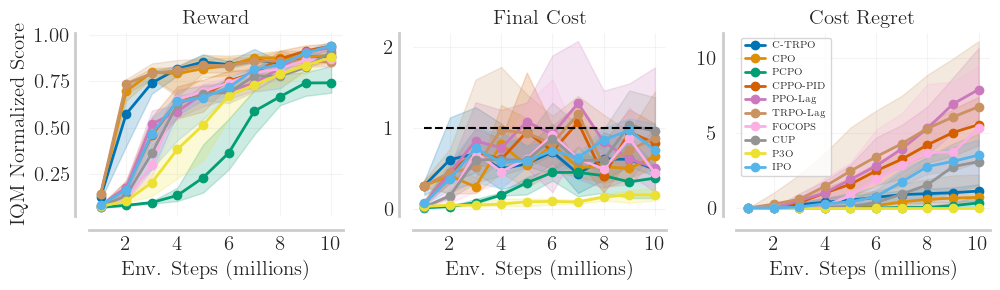

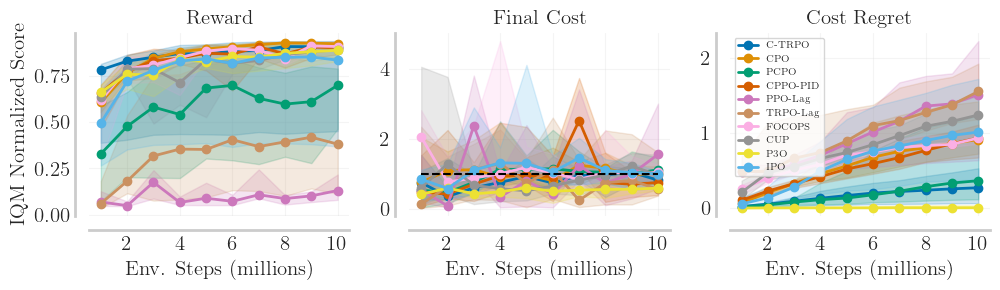

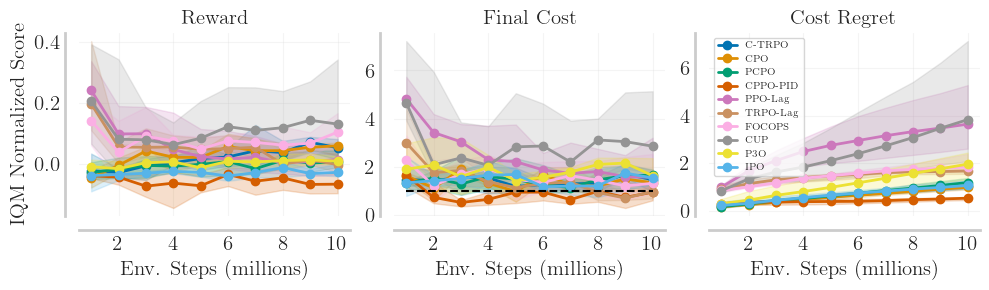

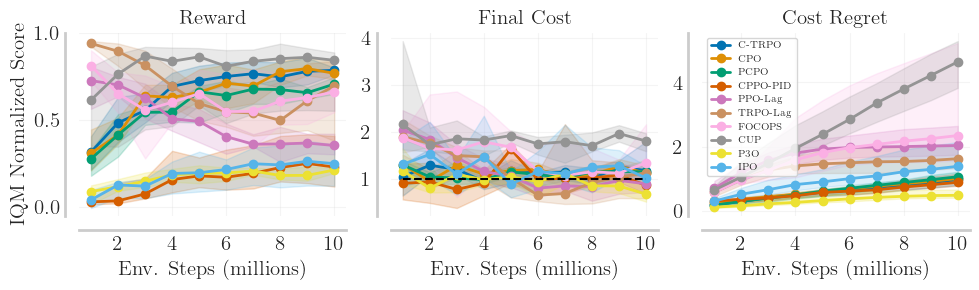

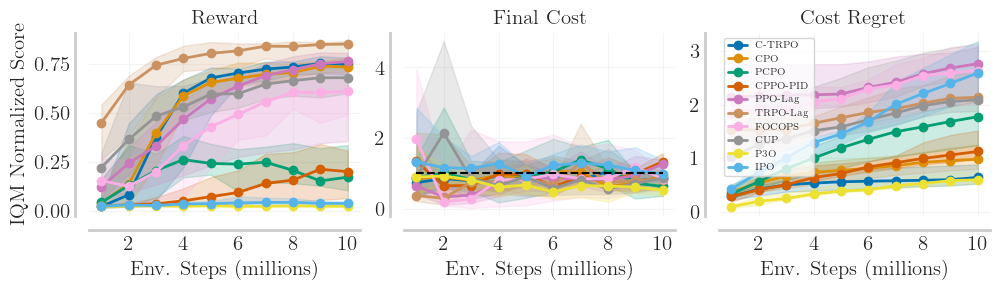

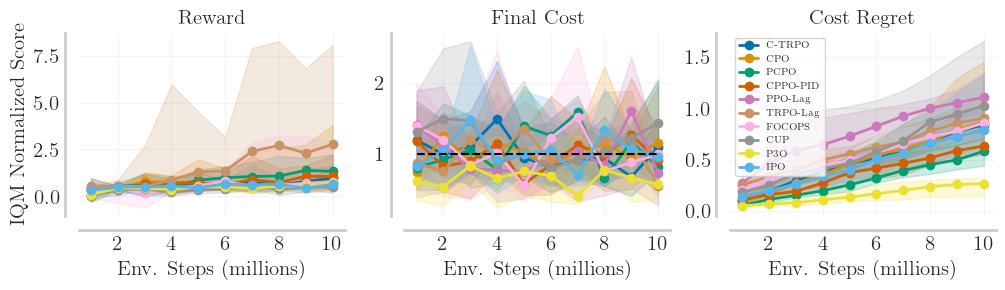

In [41]:
for env in ENVS:
    _, axs = plt.subplots(1, 3, figsize=(10, 3))

    for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
        plot_utils.plot_sample_efficiency_curve(
            np.array(range(1,11)), iqm_scores[env][metric_name], iqm_cis[env][metric_name], algorithms=ALGOS, ax=ax,
            xlabel=r'Env. Steps (millions)',
            ylabel="IQM Normalized Score" if i == 0 else "",
            labelsize=15,
            ticklabelsize=15,
            # legend=True if (i == 0) else False,
        )

        # Cost Regret is a better term
        ax.set_title("Cost Regret" if metric_name == "Cumulative Cost" else metric_name, fontsize=15)
        ax.set_xticks([2, 4, 6, 8, 10])
    
    axs[1].plot([1, 10], [1, 1], color="black", linestyle="dashed", label="limit", zorder=10)

    plt.legend(prop={'size': 7})

    plt.tight_layout()

    plt.savefig(os.path.join("..", "graphics", f"benchmark_samples_{env}.pdf"), dpi=600)

In [44]:
import numpy as np

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for metric in metrics:
    normalized_score_dict_samples[metric] = {}
    for i, env in enumerate(ENVS):
        for algo in ALGOS:
            normalized_score_dict_samples[metric][algo] = np.zeros((5, len(ENVS), 10))
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                if metric == "Metrics/EpRet":
                    norm = df_filtered[(df_filtered["algo"]=="PPO") & (df_filtered["Train/TotalSteps"] == 10_000_000)][metric].mean()
                elif metric == "Metrics/EpCost":
                    norm = 25.0
                else:  # "Metrics/EpCumCostViolation"
                    norm = df_filtered[(df_filtered["algo"]=="CPO") & (df_filtered["Train/TotalSteps"] == 10_000_000)][metric].mean()
                data = np.array(df_filtered[(df_filtered["algo"]==algo) & (df_filtered["Train/TotalSteps"] == step)][metric])
                if not data.size == 0:
                    normalized_score_dict_samples[metric][algo][:,i,j] = data / norm
                else:
                    print(f"Warning: empty data for {algo}, {env}")

In [46]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

iqm_scores, iqm_cis = {}, {}

for metric, metric_name in zip(metrics, metric_names):
    iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                  for frame in range(scores.shape[-1])])

    iqm_scores[metric_name], iqm_cis[metric_name] = rly.get_interval_estimates(
        normalized_score_dict_samples[metric], iqm, reps=50000)

FileNotFoundError: [Errno 2] No such file or directory: 'img/benchmark_samples_aggregate.pdf'

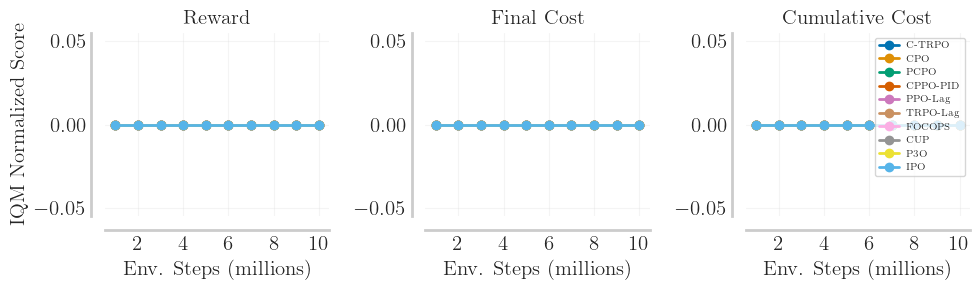

In [47]:

_, axs = plt.subplots(1, 3, figsize=(10, 3))

for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
    plot_utils.plot_sample_efficiency_curve(
        np.array(range(1,11)), iqm_scores[metric_name], iqm_cis[metric_name], algorithms=ALGOS, ax=ax,
        xlabel=r'Env. Steps (millions)',
        ylabel="IQM Normalized Score" if i == 0 else "",
        labelsize=15,
        ticklabelsize=15,
        # legend=True if (i == 0) else False,
    )

    ax.set_title(metric_name, fontsize=15)
    ax.set_xticks([2, 4, 6, 8, 10])

plt.legend(prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("img", f"benchmark_samples_aggregate.pdf"), dpi=600)